This notebook was setup for a blog post on setting up the full bayesian model of Fader & Hardie (2011) to model customer repeat transactions. Check out the blog post here: 

https://sidravi1.github.io/blog/2018/07/08/fader-hardie-clv/

In [22]:
%matplotlib inline

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm

## Setup PYMC3 model

In [5]:
import pymc3 as pm
import numpy as np
import datetime

import theano.tensor as tt
from theano.ifelse import ifelse

In [6]:
# from: http://www.brucehardie.com/notes/004/
data_bgn = pd.read_excel("./bgnbd.xls", sheetname='Raw Data')

In [7]:
n_vals = len(data_bgn)
x = data_bgn['x'].values
t_x = data_bgn['t_x'].values
T = data_bgn['T'].values 

int_vec = np.vectorize(int)
x_zero = int_vec(x > 0)

In [211]:
with pm.Model() as model:
        
    a = pm.HalfCauchy('a',4)
    b = pm.HalfCauchy('b',4)
    
    alpha = pm.HalfCauchy('alpha',4)
    r = pm.HalfCauchy('beta',4)
    
    lam = pm.Gamma('lam', alpha, r, shape=n_vals)
    p = pm.Beta('p',a, b, shape=n_vals)
    
    # expected_all = pm.Deterministic('expected_all', (1/p)*(-tt.expm1(-lam * p * T)))
    
    def logp(x, t_x, T, x_zero):

        log_termA = tt.mul(x,tt.log(1-p)) + tt.mul(x,tt.log(lam)) - tt.mul(t_x,lam)

        termB_1 = tt.mul(-lam,(T - t_x))
        termB_2 = tt.log(p) - tt.log(1-p)
        
        log_termB = pm.math.switch(x_zero, pm.math.logaddexp(termB_1, termB_2), termB_1)
        
        return tt.sum(log_termA) + tt.sum(log_termB)
    
    like = pm.DensityDist('like', logp, observed = {'x':x, 't_x':t_x, 'T':T, 'x_zero':x_zero})
    

In [212]:
with model:
    trace = pm.sample(draws=6000, target_accept = 0.95, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_logodds__, lam_log__, beta_log__, alpha_log__, b_log__, a_log__]
100%|██████████| 9000/9000 [17:01<00:00,  8.81it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


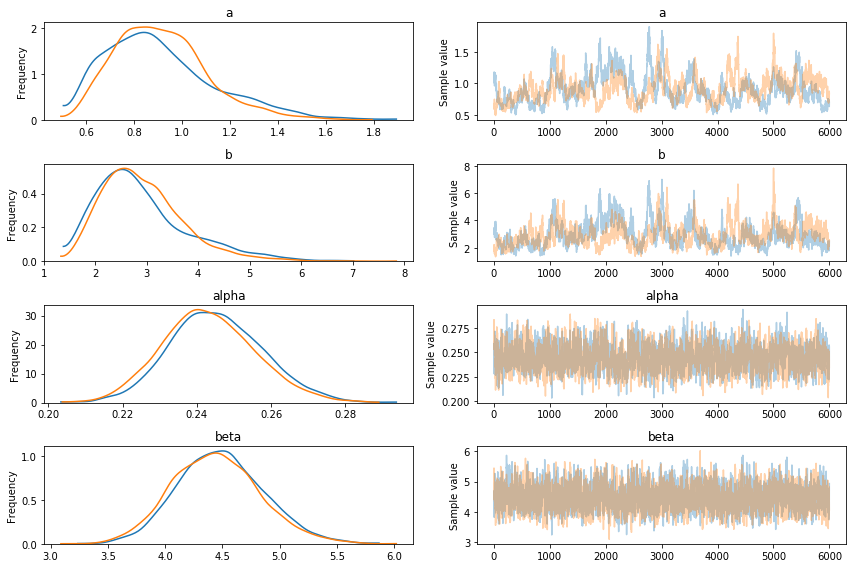

In [213]:
_ = pm.traceplot(trace, varnames=['a','b','alpha','beta'])

## Posteriors for hypers

In [216]:
a_post = trace['a']
b_post = trace['b']
alpha_post = trace['alpha']
r_post = trace['r']

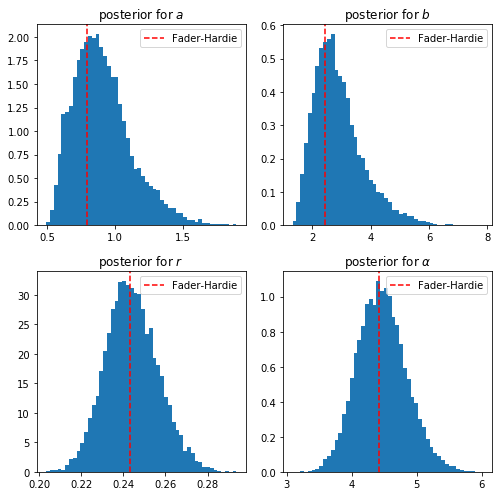

In [232]:
plt.figure(figsize=(7,7))
ax = plt.subplot(221)
ax.hist(a_post, bins=50, density=True)
ax.set_title(r"posterior for $a$")
ax.axvline(0.793, ls="--", color='r', label="Fader-Hardie")
ax.legend()

ax = plt.subplot(222)
ax.hist(b_post, bins=50, density=True)
ax.set_title(r"posterior for $b$")
ax.axvline(2.426, ls="--", color='r', label="Fader-Hardie")
ax.legend()

ax = plt.subplot(223)
ax.hist(alpha_post, bins=50, density=True)
ax.set_title(r"posterior for $r$")
ax.axvline(0.243, ls="--", color='r', label="Fader-Hardie")
ax.legend()

ax = plt.subplot(224)
ax.hist(r_post, bins=50, density=True)
ax.set_title(r"posterior for $\alpha$")
ax.axvline(4.414, ls="--", color='r', label="Fader-Hardie")
ax.legend()

plt.tight_layout()
plt.savefig("../../sidravi1.github.io/assets/2018-07-08_fader_posteriors.png")

## Model Checks

In [96]:
p_post = trace['p']
lam_post = trace['lam']

In [147]:
expected_all = (1/p_post)*(-np.expm1(-lam_post * p_post * T))

In [193]:
gr = pm.gelman_rubin(trace)

np.any(gr['expected_all'] > 1.01), np.any(gr['p'] > 1.01), np.any(gr['lam'] > 1.01)

(False, False, False)

In [182]:
out = pm.geweke(trace, intervals=10)

In [197]:
out[1]['expected_all']

[array([[  0.00000000e+00,   8.95080360e-04],
        [  3.33000000e+02,   1.52894892e-02],
        [  6.66000000e+02,   3.10793757e-02],
        [  9.99000000e+02,   3.10421241e-02],
        [  1.33200000e+03,   3.64511443e-02],
        [  1.66500000e+03,  -1.37252010e-02],
        [  1.99800000e+03,   3.08666401e-02],
        [  2.33100000e+03,  -3.89996788e-02],
        [  2.66400000e+03,  -1.58229033e-02],
        [  2.99700000e+03,  -1.19032942e-02]]),
 array([[  0.00000000e+00,   7.05878554e-02],
        [  3.33000000e+02,   2.18597084e-02],
        [  6.66000000e+02,  -9.80355245e-02],
        [  9.99000000e+02,  -7.66319576e-02],
        [  1.33200000e+03,  -1.23958184e-02],
        [  1.66500000e+03,  -8.11218047e-02],
        [  1.99800000e+03,  -7.32895108e-04],
        [  2.33100000e+03,  -5.20430856e-02],
        [  2.66400000e+03,  -7.18538900e-02],
        [  2.99700000e+03,  -9.15044977e-02]]),
 array([[  0.00000000e+00,  -1.70076971e-02],
        [  3.33000000e+02,   4

(0, 3500)

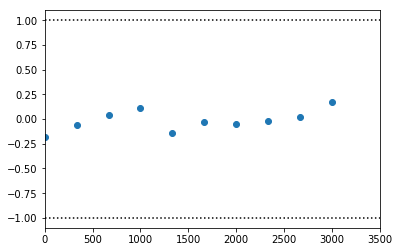

In [207]:
plt.scatter(*out[1]['a'].T)
plt.hlines([-1,1], 0, 3500, linestyles='dotted')
plt.xlim(0, 3500)

(0, 3500)

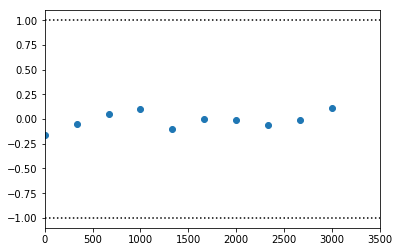

In [208]:
plt.scatter(*out[1]['b'].T)
plt.hlines([-1,1], 0, 3500, linestyles='dotted')
plt.xlim(0, 3500)

(0, 3500)

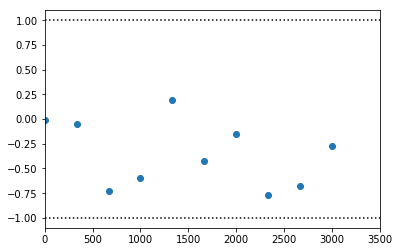

In [209]:
plt.scatter(*out[1]['alpha'].T)
plt.hlines([-1,1], 0, 3500, linestyles='dotted')
plt.xlim(0, 3500)

(0, 3500)

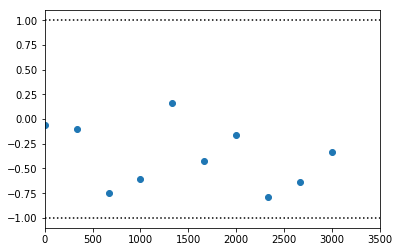

In [210]:
plt.scatter(*out[1]['beta'].T)
plt.hlines([-1,1], 0, 3500, linestyles='dotted')
plt.xlim(0, 3500)

## Posterior Predictive Checks

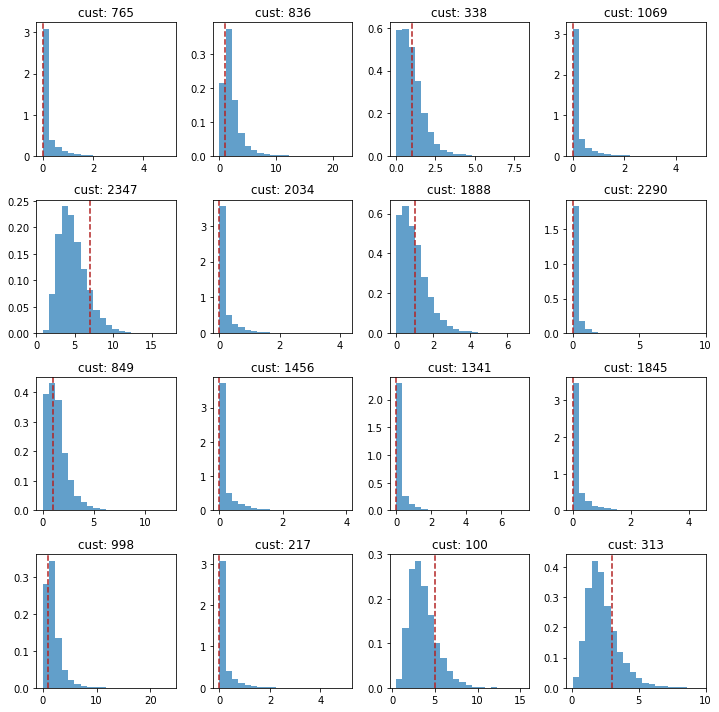

In [149]:
# pick some random idx

idx = np.random.choice(np.arange(len(x)), size=16, replace=False)
f, axes = plt.subplots(4,4, figsize=(10,10))

for ax, i in zip(axes.ravel(), idx):
    _ = ax.hist(expected_all[:,i], density=True, alpha = 0.7, bins=20)
    _ = ax.axvline(x[i],ls='--', color='firebrick')
    _ = ax.set_title('cust: {numb}'.format(numb=i))
_ = plt.tight_layout()

plt.savefig("../../sidravi1.github.io/assets/2018-07-08_fader_ppc.png")

## Testing out ADVI

In [153]:
with model:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Average Loss = 10,265: 100%|██████████| 30000/30000 [01:44<00:00, 286.13it/s]
Finished [100%]: Average Loss = 10,265


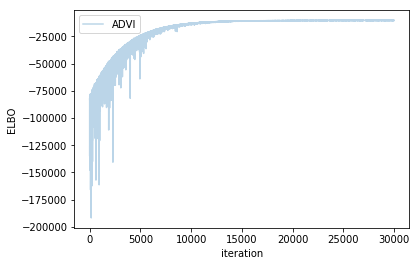

In [154]:
plt.plot(-inference.hist, label='ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [155]:
trace_approx = approx.sample(draws=12000)

In [163]:
p = trace_approx.get_values('p', chains=0)
lam = trace_approx.get_values('lam', chains=0)

expected_all_approx = (1/p)*(-np.expm1(-lam * p * T))

### How does the approximation compare?

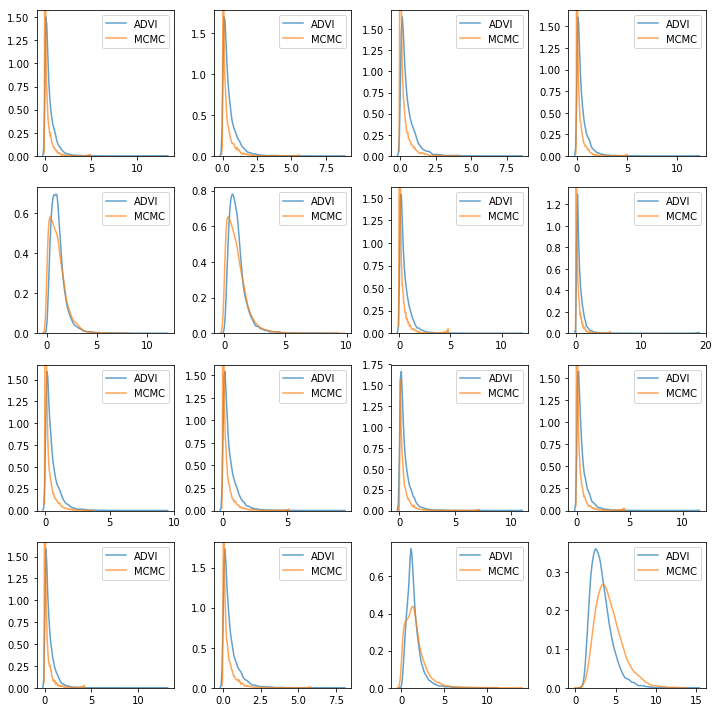

In [165]:
idx = np.random.choice(np.arange(len(x)), size=16, replace=False)
f, axes = plt.subplots(4,4, figsize=(10,10))

for ax, i in zip(axes.ravel(), idx):
    _ = sns.kdeplot(expected_all_approx[:,i], alpha = 0.7, label='ADVI', ax=ax)
    _ = sns.kdeplot(expected_all[:,i], alpha = 0.7, label='MCMC', ax=ax)
_ = plt.tight_layout()